# PULSEE $\frac{\pi}{2}$ - Pulse, a Simple Zeeman Interaction
Jiwoo Seo, Ilija N.

## Imports

In [1]:
import numpy as np

import pulsee.plot as psplt  # 'psplt' = 'pulsee plot'
from pulsee import operators as op, simulation as sim
from pulsee.pulses import Pulses
# import matplotlib.pylab as plt

## Quantum System Setup
Spin-$\frac{1}{2}$ system with $\gamma/2\pi = 5.00$ MHz/T (see Candoli thesis §4.1) and $B_0 = 1 T:

In [2]:
QUANTUM_NUMBER = 1 / 2  # spin 1/2
GAMMA_2PI = 5  # MHz/T
B0 = 1 # Tesla
W0 = -2 * np.pi * GAMMA_2PI * B0  # units of radial frequency

spin_par = {'quantum number': QUANTUM_NUMBER, 'gamma/2pi': GAMMA_2PI}
zeem_par = {'field magnitude': B0, 'theta_z': 0, 'phi_z': 0}

print('Larmor frequency:', W0 / (2 * np.pi), 'MHz')

Larmor frequency: -5.0 MHz


## Experimental Parameters

In [3]:
T2 = 2 # microS. A relatively fast T2 time for easy visualization at the end of the notebook
ACQUISITION_TIME = 100  # microS
N_POINTS_EVOLVE = 1000
N_POINTS_FID = 10000

## Run `sim.nuclear_system_setup` after setting up the arguments
Initial state is canonical by default

### Hamiltonians
Here we would add the desired Hamiltonian interaction terms.
However, this example notebook has a simple spin-1/2 system, so no interactions terms in the Hamiltonian exists and no additional arguments will be passed into `nuclear_system_setup()`.

In [4]:
spin, h_unperturbed, rho_0 = sim.nuclear_system_setup(spin_par=spin_par, zeem_par=zeem_par)

### Print out the initial state density matrix and its absorption spectrum

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.91679844 0.        ]
 [0.         0.08320156]]

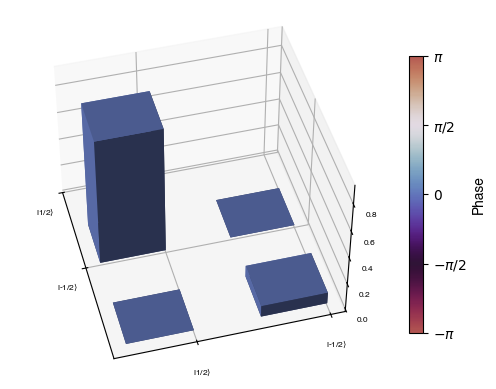

(<Figure size 640x480 with 2 Axes>, <Axes3D: >)

In [5]:
display(rho_0)
psplt.plot_complex_density_matrix(rho_0)

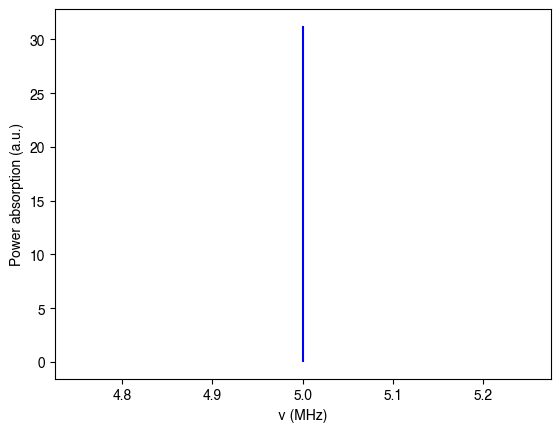

In [6]:
f, p = sim.power_absorption_spectrum(spin, h_unperturbed, normalized=True)
_ = psplt.plot_power_absorption_spectrum(f, p)

## Pulse
Set up single mode pulse of form
$$\mathbf{B}_1(t) = 2 B_1 \cos(2\pi \nu + \delta)\cdot \hat{\mathbf{n}}(\theta, \phi)$$
where $\theta$ and $\phi$ are the polar and azimuthal angles respectively.

For simplest case apply $\pi/2$ pulse with $B_1 = B_0 / 10 $, $ \nu = (\gamma/2\pi) \cdot B_0 $, $\delta = \phi =0$, $\theta=\pi/2$ --> $I_x$ pulse.

In [7]:
B1 = B0 / 100
PHASE_B1 = np.pi * 0
POLAR_B1 = np.pi / 2  # pulse direction is in the transverse plane
AZIMUTHAL_B1 = 0  # x-direction pulse
TIP_ANGLE = np.pi / 2
PULSE_TIME = TIP_ANGLE / (2 * np.pi * GAMMA_2PI * B1)  # using gamma/2pi, NOT gamma!

mode = Pulses(frequencies=[W0], amplitudes=[B1], phases=[PHASE_B1], theta_p=[POLAR_B1], phi_p=[AZIMUTHAL_B1],
              pulse_times=[PULSE_TIME])

##  Simulation

### We apply the pulse using two methods
1. The 'mesolve' method using the QuTiP's time evolution functions which uses ODE integration of the time-dependent Hamiltonian
2. The 'magnus' method, using the Magnus expansion, an analytical approximation

### mesolve:

In [8]:
evolved_dm_mesolve = sim.evolve(spin, h_unperturbed, rho_0, solver='mesolve',
                                mode=mode, n_points=100)
evolved_dm_mesolve

  0%|          | 0/99 [00:00<?, ?it/s]

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.50003919+1.26538927e-16j 0.00108562+4.16779686e-01j]
 [0.00108562-4.16779686e-01j 0.49996081-1.26538927e-16j]]

### magnus:

In [9]:
#Evolve the initial state until a square pi/2 pulse is applied using the magnus solver in the interaction picture
evolved_dm = sim.evolve(spin, h_unperturbed, rho_0, solver='magnus', picture='IP',
                        mode=mode, n_points=N_POINTS_EVOLVE, order=1)
evolved_dm

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[5.00000000e-01+0.00000000e+00j 1.35695357e-16+4.16798439e-01j]
 [1.35695357e-16-4.16798439e-01j 5.00000000e-01+4.93038066e-32j]]

In [10]:
RRF_par = {'nu_RRF': -W0 / (2 * np.pi), 'theta_RRF': 0, 'phi_RRF': 0}
RRF_par

{'nu_RRF': 5.0, 'theta_RRF': 0, 'phi_RRF': 0}

In [11]:
#Evolve the initial state until a square pi/2 pulse is applied using the magnus solver
evolved_dm_magnus = sim.evolve(spin, h_unperturbed, rho_0, solver='magnus', picture='RRF', RRF_par=RRF_par,
                               mode=mode, n_points=30, order=1)
evolved_dm_magnus

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[5.00000000e-01+0.00000000e+00j 9.69708655e-16+4.16798439e-01j]
 [9.69708655e-16-4.16798439e-01j 5.00000000e-01+9.86076132e-32j]]

### Compare to the theoretical output:
The theoretical output is simply a $\pi/2$ rotation along x of the initial state

Both methods clearly agree well with the theoretical output!

In [12]:
op.apply_rot_pulse(rho_0, np.pi / 2, spin.I['x'])

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5+0.j         0. +0.41679844j]
 [0. -0.41679844j 0.5+0.j        ]]

### Visualize the input and output:

Initial state


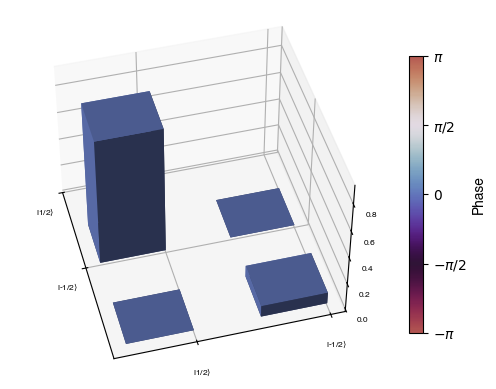

Evolved


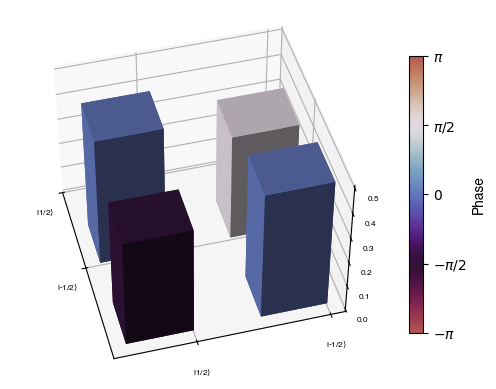

In [13]:
print('Initial state')
_ = psplt.plot_complex_density_matrix(rho_0)
print('Evolved')
_ = psplt.plot_complex_density_matrix(evolved_dm)

# Generate FID

In [14]:
t, fid = sim.FID_signal(spin, h_unperturbed, evolved_dm, acquisition_time=ACQUISITION_TIME, T2=T2, n_points=N_POINTS_FID)

In [15]:
f, ft = sim.fourier_transform_signal(fid, t, padding=2)

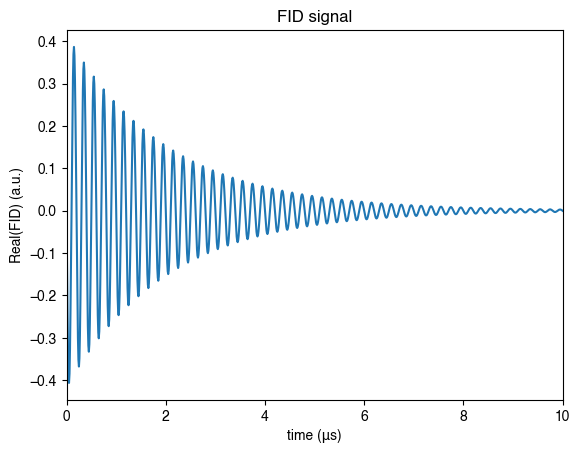

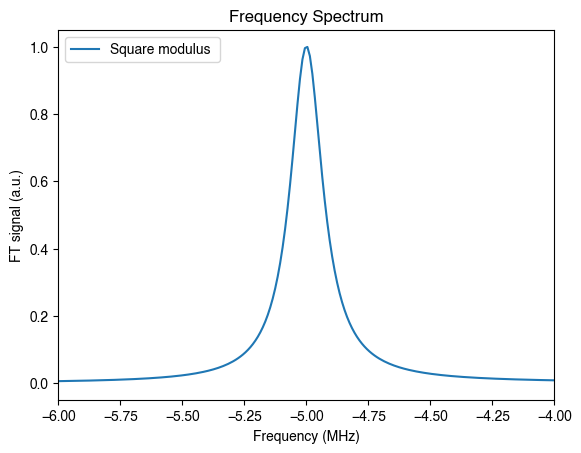

In [16]:
psplt.plot_real_part_FID_signal(t, fid, xlim=(0, 10))
_ = psplt.plot_fourier_transform(f, ft, square_modulus=True, save=False, xlim=(-6, -4))